# Phase 1 - SEIR-V Model with Economic Framework 

## Behavioral Economics of Childhood Vaccination 

This notebook implements the foundational components for analyzing vaccination economies:
1. **SEIR-V Epidemic Model**: Deterministic compartmental model with vaccination 
2. **Economic Framework**: Cost-effectiveness analysis (ICER, DALYs)
3. **Parameter Exploration**: Sensitivity to R0, coverage, and costs
4. **Model Validation**: Confirmation that measles dynamics match literature

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import sys, os 

sys.path.append(os.path.abspath(os.path.join('..','src')))

from epimodels.seir_v import SEIRVModel 
from dataio.seirv_parameters import MeaslesParameters, create_low_coverage_params

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model Setup and Parameter Review

Model parameters sourced from:
- CDC measles fact sheets
- Guerra et al. (2017) - measles epidemiology
- WHO cost-effectiveness guidelines
- US vaccine price lists

In [2]:
# initialize baseline params
params = MeaslesParameters()
params.print_summary()

MEASLES VACCINATION MODEL PARAMETERS:

--- EPIDEMIOLOGY ---
R₀: 15.0
Herd Immunity Threshold: 93.3%
Latent period: 10.0 days
Infectious period: 8.0 days
Transmission rate (β): 1.875 per day
Case fatality rate: 0.20%

--- VACCINATION ---
Vaccine efficacy (1 dose): 93%
Vaccine efficacy (2 doses): 97%
Current coverage (dose 1): 91%
Current coverage (dose 2): 88%

--- ECONOMICS ---
Vaccine delivery cost: $46.00 per dose
Hospitalization cost: $8,000
Highly cost-effective threshold: $70,000/DALY
Cost-effective threshold: $210,000/DALY


## Baseline Simulation: Current Vaccination Program

Simulating 10 years of measles transmission under current US vaccination coverage (91% dose 1, 88% dose 2)

Running baseline simulation at current coverage levels:
SEIR-V SIMULATION RESULTS:
Simulation time: 10.0 years
Population size: 1,000,000

--- EPIDEMIC OUTCOMES ---
Total cases: 116,650
Attack rate: 11.66%
Total deaths: 233
Total hospitalizations: 23,330
Peak prevalence: 0.239%
Peak time: 0.90 years

--- FINAL STATE ---
Susceptible: 78,540
Vaccinated: 847,405
Recovered: 113,023
Immune proportion: 96.0%


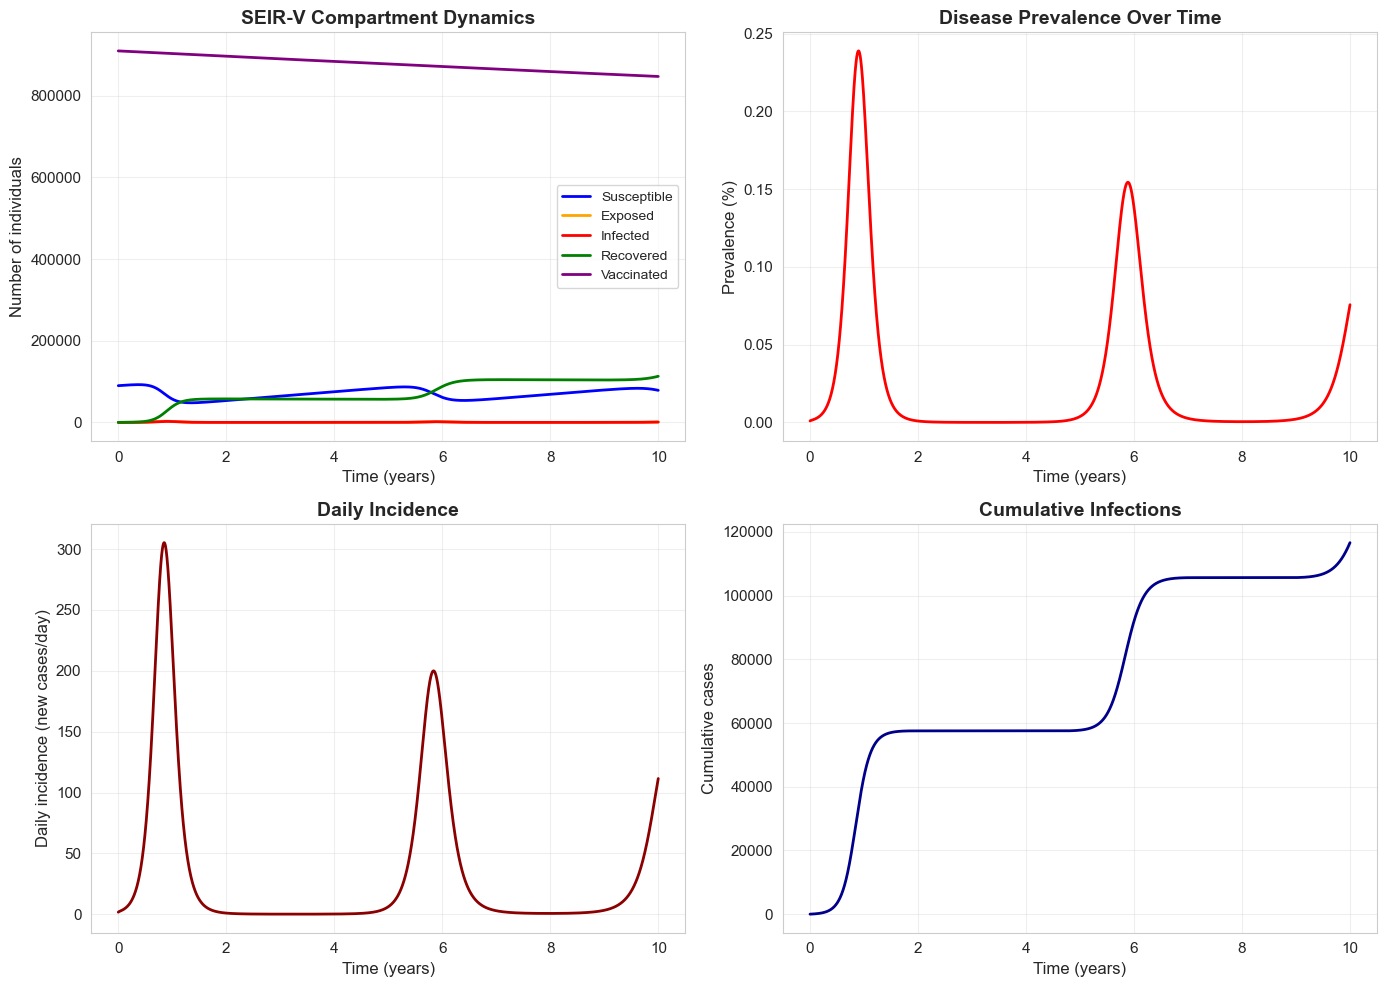

In [3]:
# initialize model with baseline parameters with current vaccination rate
params.initial_vaccinated = params.baseline_coverage_dose1
model_baseline = SEIRVModel(params)

print("Running baseline simulation at current coverage levels:")
results_baseline = model_baseline.simulate(t_max = 365*10)
model_baseline.print_summary()
model_baseline.plot_dynamics()

## Scenario Comparison: Low vaccine coverage (vaccine hesitancy)

Vaccine coverage reduced to 75% (~20% lower)

SEIR-V SIMULATION RESULTS:
Simulation time: 10.0 years
Population size: 1,000,000

--- EPIDEMIC OUTCOMES ---
Total cases: 246,064
Attack rate: 24.61%
Total deaths: 492
Total hospitalizations: 49,213
Peak prevalence: 4.137%
Peak time: 0.27 years

--- FINAL STATE ---
Susceptible: 114,608
Vaccinated: 698,041
Recovered: 228,150
Immune proportion: 92.6%


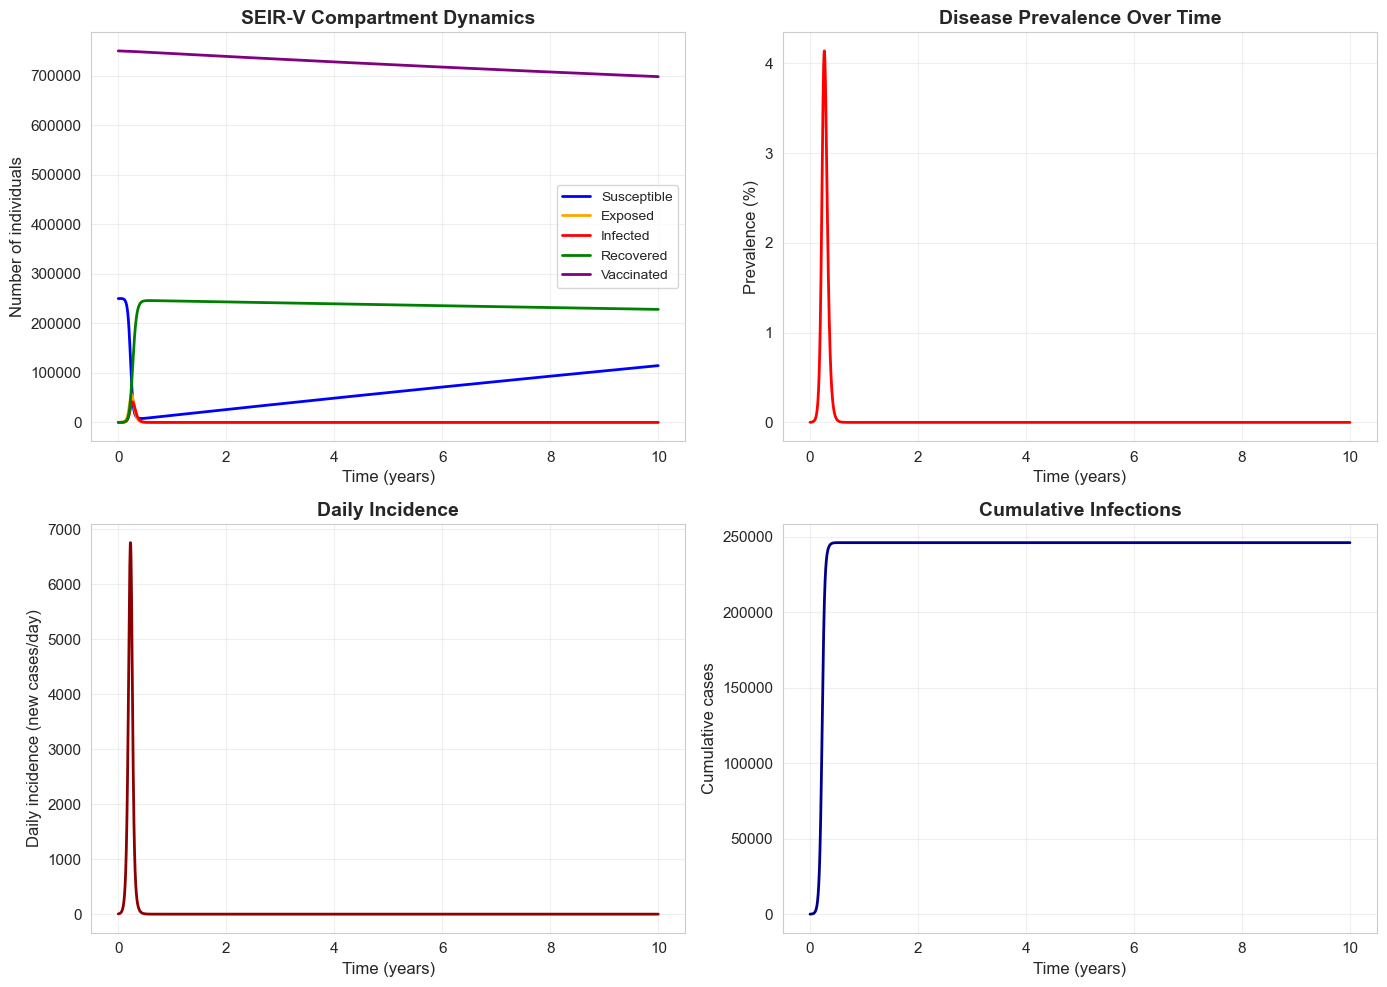

In [4]:
params_low = create_low_coverage_params() 
model_low = SEIRVModel(params_low)
results_low = model_low.simulate(t_max=365*10)
model_low.print_summary()
model_low.plot_dynamics()

### Comparison: Baseline vs. Low Coverage

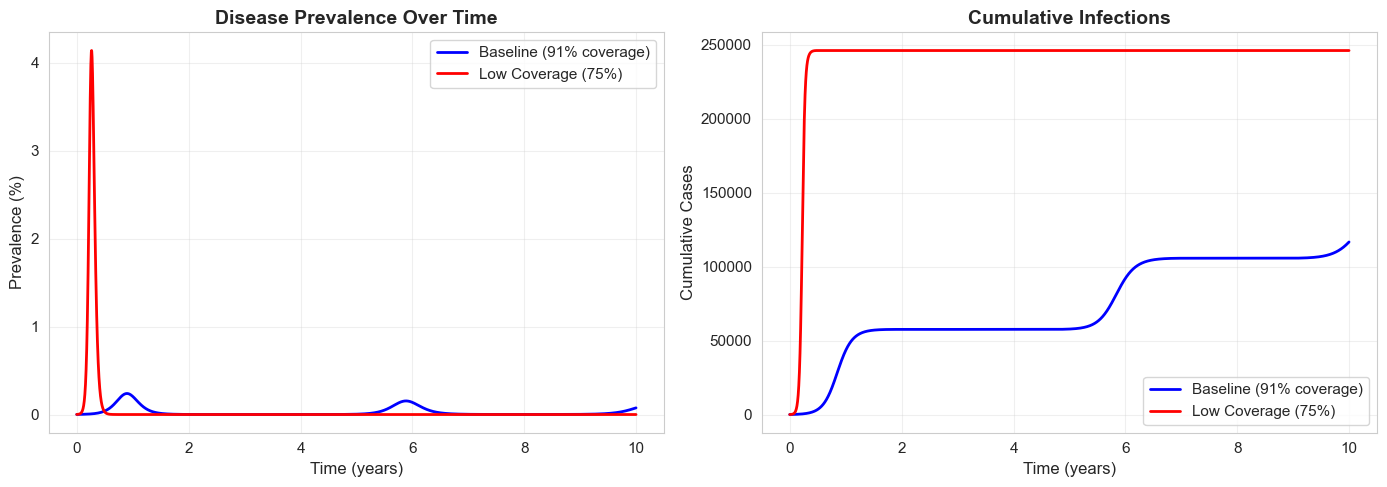


Impact of reducing coverage from 91% → 75%:
  Additional cases: 129,414
  Additional deaths: 259
  Relative increase: 110.9%


In [5]:
# Compare scenarios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prevalence comparison
ax = axes[0]
ax.plot(results_baseline['time'] / 365, 
        results_baseline['prevalence'] * 100, 
        label='Baseline (91% coverage)', linewidth=2, color='blue')
ax.plot(results_low['time'] / 365, 
        results_low['prevalence'] * 100, 
        label='Low Coverage (75%)', linewidth=2, color='red')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Prevalence (%)', fontsize=12)
ax.set_title('Disease Prevalence Over Time', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Cumulative cases
ax = axes[1]
ax.plot(results_baseline['time'] / 365, 
        results_baseline['cumulative_infections'], 
        label='Baseline (91% coverage)', linewidth=2, color='blue')
ax.plot(results_low['time'] / 365, 
        results_low['cumulative_infections'], 
        label='Low Coverage (75%)', linewidth=2, color='red')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Cumulative Cases', fontsize=12)
ax.set_title('Cumulative Infections', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate differences
outcomes_baseline = model_baseline.calculate_health_outcomes()
outcomes_low = model_low.calculate_health_outcomes()

additional_cases = outcomes_low['total_cases'] - outcomes_baseline['total_cases']
additional_deaths = outcomes_low['total_deaths'] - outcomes_baseline['total_deaths']

print(f"\nImpact of reducing coverage from 91% → 75%:")
print(f"  Additional cases: {additional_cases:,.0f}")
print(f"  Additional deaths: {additional_deaths:,.0f}")
print(f"  Relative increase: {(additional_cases / outcomes_baseline['total_cases'] * 100):.1f}%")

## Cost Effectiveness Analysis

Calculating cost-effectiveness of maintaining high vaccination coverage vs. allowing coverge to drop 